In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split

def image_directory_to_pandas(image_path):
    """
    Create a pandas DataFrame with image paths and taxonomic labels extracted from a directory structure.

    Parameters:
    ----------
    image_path : str
        The root directory containing subfolders with images.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame containing image paths and label information. Columns include:
        - 'path': The full path to the image.
        - 'folder_label': The folder name, representing the original label (format: 'family_genus_species').
        - 'family': Extracted family name from the folder label.
        - 'genus': Extracted genus name from the folder label.
        - 'species': Combination of genus and species names (e.g., 'genus species').

    Raises:
    ------
    ValueError:
        If the folder label format does not match the expected 'family_genus_species' format.
    """
    labels = []
    paths = []

    # Walk through the directory and collect image paths and labels
    for root_dir, _, filenames in os.walk(image_path):
        for filename in filenames:
            # Ignore hidden files and non-image files
            if filename.startswith('.') or os.path.splitext(filename)[1].lower() not in {".jpeg", ".png", ".jpg"}:
                continue

            # Extract the folder name as the label, ignoring 'GT' directories
            folder_label = os.path.basename(root_dir)
            if folder_label != "GT":
                labels.append(folder_label)
                paths.append(os.path.join(root_dir, filename))

    # Create DataFrame with paths and folder labels
    df = pd.DataFrame({'image_path': paths, 'folder_label': labels})
    df['folder_label'] = df['folder_label'].astype("category")

    # Split the folder_label into 'family', 'genus', and 'species'
    try:
        df[['family', 'genus', 'species']] = df['folder_label'].str.split("_", expand=True)
        df['species'] = df['genus'] + " " + df['species']
    except ValueError as e:
        raise ValueError(
            "Error splitting folder labels. Ensure that your folder structure follows 'family_genus_species' format."
        ) from e

    # Return the dataframe with specified columns
    return df[['image_path', 'folder_label', 'family', 'genus', 'species']]

def split_image_dataframe(df, test_size=0.2, val_size=0.1, random_state=42, stratify_by='folder_label'):
    """
    Split a pandas DataFrame into train, validation, and test sets,
    stratified by the 'folder_name' column.

    Args:
        df (pd.DataFrame): The DataFrame containing image paths and labels.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.
        random_state (int): Seed for random number generation for reproducibility.

    Returns:
        tuple: Three pandas DataFrames for train, validation, and test sets.
    """
    # First, split into train+validation and test sets
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df[stratify_by],
        random_state=random_state
    )
    
    # Calculate the adjusted validation size relative to the remaining train+val data
    val_relative_size = val_size / (1 - test_size)
    
    # Split the train+validation set into train and validation sets
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_relative_size,
        stratify=train_val_df[stratify_by],
        random_state=random_state
    )
    
    return train_df, val_df, test_df

def process_image_and_labels(image_path, family, genus, species, family_labels, genus_labels, species_labels, image_size=(224,224)):
    """
    Process an image and its corresponding labels for training.

    Parameters:
    ----------
    image_path : str
        The path to the image file.
    family : str
        The family label of the image.
    genus : str
        The genus label of the image.
    species : str
        The species label of the image.
    family_labels : tf.Tensor
        Tensor of unique family labels.
    genus_labels : tf.Tensor
        Tensor of unique genus labels.
    species_labels : tf.Tensor
        Tensor of unique species labels.

    Returns:
    -------
    img : tf.Tensor
        The processed image tensor.
    labels : dict
        A dictionary containing one-hot encoded labels for family, genus, and species.
    """
    # Load the raw data from the file as a string
    img = tf.io.read_file(image_path)
    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    img = tf.image.resize(img, image_size)

    # Convert family, genus, and species to indices
    family_label = tf.argmax(tf.equal(family_labels, family))
    genus_label = tf.argmax(tf.equal(genus_labels, genus))
    species_label = tf.argmax(tf.equal(species_labels, species))

    # Convert to one-hot encoded format
    family_label = tf.one_hot(family_label, len(family_labels))
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))

    # Return the image and a dictionary of labels with matching keys
    return img, {
        "family": family_label,
        "genus": genus_label,
        "species": species_label
    }

def build_dataset_from_dataframe(df, batch_size=32, image_size=(224,224)):
    """
    Build a TensorFlow dataset from a DataFrame containing image paths and taxonomic labels.

    Parameters:
    ----------
    df : pandas.DataFrame
        DataFrame containing the following columns:
        - 'path': The path to the image.
        - 'Family': The family label of the image.
        - 'Genus': The genus label of the image.
        - 'Species': The species label of the image.
    batch_size : int, optional
        Batch size for training. Default is 32.

    Returns:
    -------
    image_label_ds : tf.data.Dataset
        A TensorFlow dataset with images and one-hot encoded labels.
    family_labels : list
        A sorted list of unique family labels.
    genus_labels : list
        A sorted list of unique genus labels.
    species_labels : list
        A sorted list of unique species labels.
    """
    # Extract the unique family, genus, and species from the dataframe
    family_labels = sorted(df['family'].unique())
    genus_labels = sorted(df['genus'].unique())
    species_labels = sorted(df['species'].unique())

    # Convert family, genus, and species labels to TensorFlow tensors
    family_labels = tf.constant(family_labels)
    genus_labels = tf.constant(genus_labels)
    species_labels = tf.constant(species_labels)

    # Create a TensorFlow dataset from the dataframe's paths and labels
    path_ds = tf.data.Dataset.from_tensor_slices(
        (df['image_path'].values, df['family'].values, df['genus'].values, df['species'].values)
    )

    # Map the processing function to the dataset
    image_label_ds = path_ds.map(
        lambda path, family, genus, species: process_image_and_labels(
            path, family, genus, species, family_labels, genus_labels, species_labels, image_size=image_size
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Shuffle, batch, and prefetch the dataset
    image_label_ds = image_label_ds.shuffle(buffer_size=len(df))
    image_label_ds = image_label_ds.batch(batch_size)
    image_label_ds = image_label_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return (
        image_label_ds,
        family_labels.numpy().tolist(),
        genus_labels.numpy().tolist(),
        species_labels.numpy().tolist(),
    )

def predict_image(image_path, model, family_labels, genus_labels, species_labels, image_size=(224,224) ,top_k=3):
    """
    Predict the top-k family, genus, and species from an image using a trained model,
    and display the image with predictions.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_family: List of tuples (family, confidence) for top k family predictions.
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict family, genus, and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.image.resize(img[0], image_size) / 255.0)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print top-k predictions for each level
    print("Top 3 Family Predictions:")
    for family, confidence in top_k_family:
        print(f"{family}: {confidence:.4f}")

    print("\nTop 3 Genus Predictions:")
    for genus, confidence in top_k_genus:
        print(f"{genus}: {confidence:.4f}")

    print("\nTop 3 Species Predictions:")
    for species, confidence in top_k_species:
        print(f"{species}: {confidence:.4f}")

    return top_k_family, top_k_genus, top_k_species

def plot_training_history(history, history_fine, fine_tune_at):
    """
    Plot the training history of accuracy and loss for each output.
    
    Args:
    - history (History): History object from the initial training.
    - history_fine (History): History object from the fine-tuning phase.
    - fine_tune_at (int): Epoch at which fine-tuning began.
    """
    # Combine initial training history and fine-tuning history
    accuracy_keys = ['family_accuracy', 'genus_accuracy', 'species_accuracy']
    val_accuracy_keys = ['val_family_accuracy', 'val_genus_accuracy', 'val_species_accuracy']
    loss_keys = ['family_loss', 'genus_loss', 'species_loss']
    val_loss_keys = ['val_family_loss', 'val_genus_loss', 'val_species_loss']

    # Combine the data from the initial training and fine-tuning phases
    combined_history = {}
    for key in accuracy_keys + val_accuracy_keys + loss_keys + val_loss_keys:
        combined_history[key] = history.history.get(key, []) + history_fine.history.get(key, [])

    total_epochs = len(combined_history[accuracy_keys[0]])  # Total number of epochs including fine-tuning
    
    # Create subplots for accuracy and loss
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot accuracy for each output
    for idx, key in enumerate(accuracy_keys):
        axs[0, idx].plot(combined_history[key], label='Training Accuracy')
        axs[0, idx].plot(combined_history[val_accuracy_keys[idx]], label='Validation Accuracy')
        axs[0, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[0, idx].set_title(f'{key.replace("_accuracy", "").capitalize()} Accuracy')
        axs[0, idx].set_xlabel('Epochs')
        axs[0, idx].set_ylabel('Accuracy')
        axs[0, idx].legend()
        axs[0, idx].grid(True)
    
    # Plot loss for each output
    for idx, key in enumerate(loss_keys):
        axs[1, idx].plot(combined_history[key], label='Training Loss')
        axs[1, idx].plot(combined_history[val_loss_keys[idx]], label='Validation Loss')
        axs[1, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[1, idx].set_title(f'{key.replace("_loss", "").capitalize()} Loss')
        axs[1, idx].set_xlabel('Epochs')
        axs[1, idx].set_ylabel('Loss')
        axs[1, idx].legend()
        axs[1, idx].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    

In [2]:
df = image_directory_to_pandas("/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset")

train_df, val_df, test_df = split_image_dataframe(df, test_size=0.15, val_size=0.15, stratify_by='folder_label')

test_ds, family_labels, genus_labels, species_labels = build_dataset_from_dataframe(
    test_df, 64, (299, 299))  

print(f"Test Sample size: {len(test_df)}")

Test Sample size: 1354


2024-11-06 10:34:05.401225: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-06 10:34:05.401250: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-11-06 10:34:05.401255: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-11-06 10:34:05.401266: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-06 10:34:05.401276: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
cv_model = tf.keras.models.load_model(
    "/Users/leonardo/Documents/Projects/cryptovision/models/phorcys_large_hacpl_rn50v2_v2411051344.keras"
)


/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 80 variables whereas the saved optimizer has 84 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


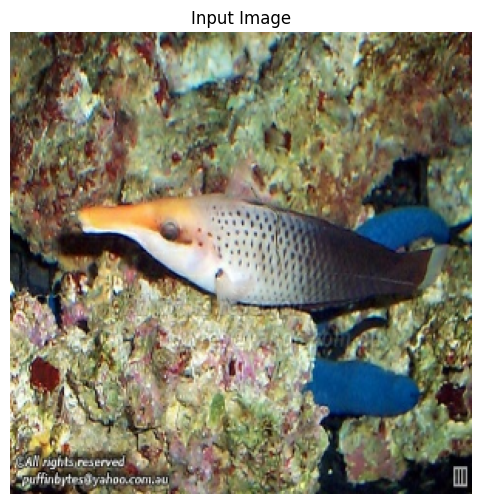

Top 3 Family Predictions:
Labridae: 0.9487
Pseudochromidae: 0.0263
Pomacentridae: 0.0091
Tetraodontidae: 0.0052
Blenniidae: 0.0020

Top 3 Genus Predictions:
Gomphosus: 0.9736
Labroides: 0.0101
Cypho: 0.0069
Pomacentrus: 0.0037
Pristiapogon: 0.0018

Top 3 Species Predictions:
Gomphosus varius: 0.9585
Labroides dimidiatus: 0.0251
Cypho purpurascens: 0.0054
Pristiapogon kallopterus: 0.0022
Pomacentrus amboinensis: 0.0021


image_path      /Users/leonardo/Documents/Projects/cryptovisio...
folder_label                            Labridae_Gomphosus_varius
family                                                   Labridae
genus                                                   Gomphosus
species                                          Gomphosus varius
Name: 802, dtype: object

In [32]:
row = 780

top_k_family, top_k_genus, top_k_species = predict_image(
    test_df['image_path'].iloc[row],
    cv_model,
    family_lbl_2, 
    genus_lbl_2, 
    species_lbl_2,
    (299, 299),
    5,
)

test_df.iloc[row]

In [26]:
top_k_genus

[(b'Apogon', 0.972),
 (b'Fowleria', 0.007793),
 (b'Trimma', 0.00359),
 (b'Priolepis', 0.003023),
 (b'Cypho', 0.002975)]

In [27]:
family_labels

[b'Apogonidae',
 b'Blenniidae',
 b'Chaenopsidae',
 b'Chaetodontidae',
 b'Cirrhitidae',
 b'Creediidae',
 b'Gobiidae',
 b'Labridae',
 b'Plesiopidae',
 b'Pomacanthidae',
 b'Pomacentridae',
 b'Pseudochromidae',
 b'Sciaenidae',
 b'Scorpaenidae',
 b'Serranidae',
 b'Syngnathidae',
 b'Tetraodontidae',
 b'Tripterygiidae']

In [28]:
def create_labels_from_path(path):
    """
    Create labels for family, genus, and species based on the input path.
    """
                
    family_labels = []
    genus_labels = []
    species_labels = []                
                    
    for root_dir, dirs, files in os.walk(path):
        for folder_name in dirs:
            family_name, genus_name, species_name = folder_name.split('_')
            family_labels.append(family_name)
            genus_labels.append(genus_name)
            species_labels.append(f"{genus_name} {species_name}")
        

    family_labels = sorted(list(set(family_labels)))
    genus_labels = sorted(list(set(genus_labels)))
    species_labels = sorted(list(set(species_labels)))
    
    return family_labels, genus_labels, species_labels

family_lbl_2, genus_lbl_2, species_lbl_2 = create_labels_from_path(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset"
)